# PMF–ALS Experiment: Testing Subspace Invariance Theory

## Core Theoretical Claim

**When ALS is initialized in the subspace spanned by specific singular vectors of Y, it will:**
1. **Stay in that subspace** (subspace invariance)
2. **Converge to the stationary point** obtained by soft-thresholding the corresponding singular values

## Mathematical Setup

- **MAP Objective:** $L(U,V) = \frac{1}{2}\|Y - UV^\top\|_F^2 + \frac{\lambda}{2}(\|U\|_F^2 + \|V\|_F^2)$
- **Global Minimizer:** $U^* = F_R \text{diag}\big(\sqrt{(\sigma_i - \lambda)_+}\big)$, $V^* = G_R \text{diag}\big(\sqrt{(\sigma_i - \lambda)_+}\big)$
- **Soft-thresholding:** $(x)_+ = \max(x,0)$

## 1. Setup: Parameters and Data Generation

In [25]:
import numpy as np
import numpy.linalg as npl

# Fixed seed for reproducibility
np.random.seed(42)

# === EXPERIMENT PARAMETERS ===
# Matrix dimensions (smaller for clarity)
m, n = 10, 8
true_rank = 4

# Clean integer singular values (hardcoded for interpretability)
# add some noise to singular values
singular_values = [10, 8, 4, 1] 

# ALS parameters
R = 3                  # Latent factorization rank
lambda_reg = 2         # Regularization parameter

# Subspace selection
top_indices = [0, 1, 2]        # Top 3 singular vectors
alt_indices = [1, 2, 3]        # Alternative 3 (overlapping set)

print("=== EXPERIMENT SETUP ===")
print(f"Matrix size: {m} × {n}")
print(f"Singular values: {singular_values}")
print(f"Regularization λ = {lambda_reg}")
print(f"Latent rank R = {R}")
print(f"Top subspace indices: {top_indices}")
print(f"Alt subspace indices: {alt_indices}")

=== EXPERIMENT SETUP ===
Matrix size: 10 × 8
Singular values: [10, 8, 4, 1]
Regularization λ = 2
Latent rank R = 3
Top subspace indices: [0, 1, 2]
Alt subspace indices: [1, 2, 3]


In [26]:
# Generate synthetic matrix with known structure
# Y = U_true * S_true * V_true^T
U_true, _ = np.linalg.qr(np.random.randn(m, true_rank))
V_true, _ = np.linalg.qr(np.random.randn(n, true_rank))
Y = U_true @ np.diag(singular_values) @ V_true.T

# Compute SVD of Y (should recover our structure)
U_svd, s_svd, Vt_svd = npl.svd(Y, full_matrices=False)
V_svd = Vt_svd.T

print("\n=== DATA GENERATION VERIFICATION ===")
print(f"Y shape: {Y.shape}")
print(f"Recovered singular values: {s_svd[:4].round(6)}")
print(f"Expected singular values:  {singular_values}")
print(f"Match: {np.allclose(s_svd[:4], singular_values)}")


=== DATA GENERATION VERIFICATION ===
Y shape: (10, 8)
Recovered singular values: [10.  8.  4.  1.]
Expected singular values:  [10, 8, 4, 1]
Match: True


## 2. Theory: Expected Solutions via Soft-Thresholding

In [27]:
def soft_threshold(sigma, lam):
    """Apply soft-thresholding: max(sigma - lambda, 0)"""
    return np.maximum(sigma - lam, 0.0)

def compute_map_solution(U_svd_subset, V_svd_subset, sigma_subset, lam):
    """Compute MAP solution U*, V* for given subspace"""
    # Apply soft-thresholding to get target scalings
    target_scales = np.sqrt(soft_threshold(sigma_subset, lam))
    
    # Form MAP solution matrices
    U_target = U_svd_subset @ np.diag(target_scales)
    V_target = V_svd_subset @ np.diag(target_scales)
    
    return U_target, V_target, target_scales

# Extract subspace components
U_svd_top = U_svd[:, top_indices]
V_svd_top = V_svd[:, top_indices] 
sigma_top = s_svd[top_indices]

U_svd_alt = U_svd[:, alt_indices]
V_svd_alt = V_svd[:, alt_indices]
sigma_alt = s_svd[alt_indices]

# Compute theoretical MAP solutions
U_target_top, V_target_top, scales_top = compute_map_solution(U_svd_top, V_svd_top, sigma_top, lambda_reg)
U_target_alt, V_target_alt, scales_alt = compute_map_solution(U_svd_alt, V_svd_alt, sigma_alt, lambda_reg)

print("=== SOFT-THRESHOLDING ANALYSIS ===")
print(f"Regularization λ = {lambda_reg}")
print()
print(f"Top subspace (indices {top_indices}):")
print(f"  Singular values: {sigma_top.round(2)}")
print(f"  After thresholding: {soft_threshold(sigma_top, lambda_reg).round(2)}")
print(f"  Target scales: {scales_top.round(3)}")
print()
print(f"Alt subspace (indices {alt_indices}):")
print(f"  Singular values: {sigma_alt.round(2)}")
print(f"  After thresholding: {soft_threshold(sigma_alt, lambda_reg).round(2)}")
print(f"  Target scales: {scales_alt.round(3)}")

=== SOFT-THRESHOLDING ANALYSIS ===
Regularization λ = 2

Top subspace (indices [0, 1, 2]):
  Singular values: [10.  8.  4.]
  After thresholding: [8. 6. 2.]
  Target scales: [2.828 2.449 1.414]

Alt subspace (indices [1, 2, 3]):
  Singular values: [8. 4. 1.]
  After thresholding: [6. 2. 0.]
  Target scales: [2.449 1.414 0.   ]


## 3. Initialize: Set ALS Starting Points

In [28]:
def initialize_in_subspace(U_svd_subset, V_svd_subset, scale_range=(0.5, 2.0)):
    """Initialize U0, V0 in given subspace with random scalings"""
    R = U_svd_subset.shape[1]
    
    # Random scaling factors
    scales_U = np.random.uniform(scale_range[0], scale_range[1], R)
    scales_V = np.random.uniform(scale_range[0], scale_range[1], R)
    
    # Initialize in subspace with random scalings
    U0 = U_svd_subset @ np.diag(scales_U)
    V0 = V_svd_subset @ np.diag(scales_V)
    
    return U0, V0, scales_U, scales_V

# Initialize ALS starting points in each subspace
U0_top, V0_top, init_scales_U_top, init_scales_V_top = initialize_in_subspace(U_svd_top, V_svd_top)
U0_alt, V0_alt, init_scales_U_alt, init_scales_V_alt = initialize_in_subspace(U_svd_alt, V_svd_alt)

print("=== INITIALIZATION ===")
print(f"Top subspace - Initial U scales: {init_scales_U_top.round(2)}")
print(f"Top subspace - Initial V scales: {init_scales_V_top.round(2)}")
print(f"Alt subspace - Initial U scales: {init_scales_U_alt.round(2)}")
print(f"Alt subspace - Initial V scales: {init_scales_V_alt.round(2)}")
print()
print("Key insight: ALS should adjust these random scalings to the optimal target scales!")

=== INITIALIZATION ===
Top subspace - Initial U scales: [1.66 1.24 1.28]
Top subspace - Initial V scales: [1.14 0.54 0.66]
Alt subspace - Initial U scales: [0.55 1.45 0.97]
Alt subspace - Initial V scales: [1.26 1.86 0.87]

Key insight: ALS should adjust these random scalings to the optimal target scales!


## 4. Run: Execute ALS Algorithm

In [29]:
def als_algorithm(Y, U0, V0, lam, max_iterations=100, tolerance=1e-10, verbose=True):
    """Run ALS algorithm with convergence tracking"""
    U, V = U0.copy(), V0.copy()
    obj_prev = np.inf
    
    for iteration in range(max_iterations):
        # ALS updates
        VtV_reg = V.T @ V + lam * np.eye(V.shape[1])
        U = Y @ V @ npl.inv(VtV_reg)
        
        UtU_reg = U.T @ U + lam * np.eye(U.shape[1])
        V = Y.T @ U @ npl.inv(UtU_reg)
        
        # Compute objective
        residual = Y - U @ V.T
        obj = 0.5 * np.sum(residual**2) + 0.5 * lam * (np.sum(U**2) + np.sum(V**2))
        
        # Check convergence
        rel_change = abs(obj_prev - obj) / max(1.0, obj_prev)
        if rel_change < tolerance:
            if verbose:
                print(f"  Converged after {iteration + 1} iterations (rel_change: {rel_change:.2e})")
            break
        
        obj_prev = obj
    
    return U, V, obj, iteration + 1

print("=== RUNNING ALS ===")
print("Top subspace:")
U_result_top, V_result_top, obj_top, iters_top = als_algorithm(Y, U0_top, V0_top, lambda_reg)

print("\nAlt subspace:")
U_result_alt, V_result_alt, obj_alt, iters_alt = als_algorithm(Y, U0_alt, V0_alt, lambda_reg)

print(f"\nFinal objectives:")
print(f"  Top subspace: {obj_top:.6f}")
print(f"  Alt subspace: {obj_alt:.6f}")

=== RUNNING ALS ===
Top subspace:
  Converged after 12 iterations (rel_change: 3.35e-11)

Alt subspace:
  Converged after 9 iterations (rel_change: 3.29e-11)

Final objectives:
  Top subspace: 38.500000
  Alt subspace: 70.500000


/var/folders/d2/m1r5k9xs77n9kj281b15qkgw0000gn/T/ipykernel_8777/3752252611.py:19: RuntimeWarning: invalid value encountered in scalar divide
  rel_change = abs(obj_prev - obj) / max(1.0, obj_prev)


## 5. Validate: Check Convergence Results

In [30]:
def validate_convergence(U_result, V_result, U_target, V_target, test_name, 
                        tol_reconstruction=1e-4):
    """Comprehensive validation of ALS convergence"""
    
    # 1. Reconstruction error (should be ~0 if found correct solution)
    reconstruction_result = U_result @ V_result.T
    reconstruction_target = U_target @ V_target.T
    reconstruction_error = np.linalg.norm(reconstruction_result - reconstruction_target, 'fro')
    
    # 2. Scaling consistency via Gram matrices
    gram_U_error = np.linalg.norm(U_result.T @ U_result - U_target.T @ U_target, 'fro')
    gram_V_error = np.linalg.norm(V_result.T @ V_result - V_target.T @ V_target, 'fro')
    
    # Overall pass/fail
    reconstruction_ok = reconstruction_error <= tol_reconstruction
    overall_pass = reconstruction_ok
    
    status = "PASS ✓" if overall_pass else "FAIL ✗"
    
    print(f"\n{test_name}")
    print(f"  Status: {status}")
    print(f"  Reconstruction error: {reconstruction_error:.2e}")
    print(f"  Gram matrix errors: U={gram_U_error:.2e}, V={gram_V_error:.2e}")
    
    return {
        'status': status,
        'overall_pass': overall_pass,
        'reconstruction_error': reconstruction_error,
        'gram_U_error': gram_U_error,
        'gram_V_error': gram_V_error
    }

print("=== VALIDATION RESULTS ===")

# Test 1: Top subspace should converge to global minimum
result_top = validate_convergence(U_result_top, V_result_top, U_target_top, V_target_top, 
                                 "Test 1: Top subspace → Global minimum")

# Test 2: Alt subspace should converge to saddle point
result_alt = validate_convergence(U_result_alt, V_result_alt, U_target_alt, V_target_alt,
                                 "Test 2: Alt subspace → Saddle point")

# Diagnostic: Check if alt escaped to top solution (should be FAIL)
result_escape = validate_convergence(U_result_alt, V_result_alt, U_target_top, V_target_top,
                                   "Diagnostic: Alt → Top (should FAIL)")

=== VALIDATION RESULTS ===

Test 1: Top subspace → Global minimum
  Status: PASS ✓
  Reconstruction error: 8.76e-06
  Gram matrix errors: U=4.38e-05, V=2.63e-05

Test 2: Alt subspace → Saddle point
  Status: PASS ✓
  Reconstruction error: 6.62e-06
  Gram matrix errors: U=2.65e-05, V=1.32e-05

Diagnostic: Alt → Top (should FAIL)
  Status: FAIL ✗
  Reconstruction error: 8.00e+00
  Gram matrix errors: U=4.90e+00, V=4.90e+00


## 6. Summary: Final Results

In [31]:
print("\n" + "="*50)
print("EXPERIMENT SUMMARY")
print("="*50)

print(f"\nMatrix: {m}×{n}, Rank: {true_rank}, Regularization: λ={lambda_reg}")
print(f"Singular values: {singular_values}")
print(f"Latent rank: R={R}")

print(f"\nSubspace Selection:")
print(f"  Top indices {top_indices}: σ = {sigma_top.round(1)} → target scales = {scales_top.round(2)}")
print(f"  Alt indices {alt_indices}: σ = {sigma_alt.round(1)} → target scales = {scales_alt.round(2)}")

print(f"\nTheoretical Prediction:")
print(f"  ALS should stay within initialized subspace")
print(f"  ALS should find MAP scaling via soft-thresholding formula")

print(f"\nExperimental Results:")
print(f"  Test 1 (Top → Global): {result_top['status']}")
print(f"  Test 2 (Alt → Saddle): {result_alt['status']}")
print(f"  Diagnostic (Alt → Top): {result_escape['status']} (expected to fail)")

both_pass = result_top['overall_pass'] and result_alt['overall_pass']
print("="*50)


EXPERIMENT SUMMARY

Matrix: 10×8, Rank: 4, Regularization: λ=2
Singular values: [10, 8, 4, 1]
Latent rank: R=3

Subspace Selection:
  Top indices [0, 1, 2]: σ = [10.  8.  4.] → target scales = [2.83 2.45 1.41]
  Alt indices [1, 2, 3]: σ = [8. 4. 1.] → target scales = [2.45 1.41 0.  ]

Theoretical Prediction:
  ALS should stay within initialized subspace
  ALS should find MAP scaling via soft-thresholding formula

Experimental Results:
  Test 1 (Top → Global): PASS ✓
  Test 2 (Alt → Saddle): PASS ✓
  Diagnostic (Alt → Top): FAIL ✗ (expected to fail)


In [32]:
# =========================
# Part 2 — Incomplete data
# Soft-Impute (MM) section
# Assumptions carried from Part 1:
#   - Y: (n x p) data matrix (fully observed)
#   - R: target rank
#   - Either 'lam' (isotropic scalar) OR 'Lambda' (R x R diagonal) is defined (NOT both).
# =========================
import numpy as np
import numpy.linalg as npl

print("[Part 2] Starting incomplete-data soft-impute section.")
print(f"[Part 2] Using existing Y with shape={Y.shape}, target rank R={R}.")
lam = lambda_reg

# Sanity: exactly one of lam or Lambda should be provided.
lam_defined = 'lam' in globals() and lam is not None
Lambda_defined = 'Lambda' in globals() and Lambda is not None

if lam_defined and not Lambda_defined:
    print(f"[Part 2] Isotropic prior: lam = {lam:.6g}")
elif Lambda_defined and not lam_defined:
    print(f"[Part 2] Diagonal prior: diag(Lambda) = {np.diag(Lambda)}")
else:
    raise ValueError("[Part 2] Please define exactly one: either 'lam' (scalar) OR 'Lambda' (diagonal R x R).")


[Part 2] Starting incomplete-data soft-impute section.
[Part 2] Using existing Y with shape=(10, 8), target rank R=3.
[Part 2] Isotropic prior: lam = 2


In [33]:
# --- Cell 1: Mask utilities and masked MAP loss (supports lam OR diagonal Lambda) ---

def make_mask(Y, pi=0.20, seed=0):
    """Return a binary mask M with P(M_ij = 1) = 1 - pi (observed)."""
    rng = np.random.default_rng(seed)
    M = (rng.random(size=Y.shape) > pi).astype(float)
    return M

def masked_map_loss(Y, M, U, V, lam=None, Lambda=None):
    """
    Masked loss:
      0.5 * || M ⊙ (Y - U V^T) ||_F^2 + 0.5 * [ lam*(||U||_F^2 + ||V||_F^2) ]  (if lam)
      0.5 * || M ⊙ (Y - U V^T) ||_F^2 + 0.5 * [ tr(U^T Λ U) + tr(V^T Λ V) ]      (if Lambda)
    Exactly one of lam or Lambda must be provided.
    """
    Rmask = M * (Y - U @ V.T)
    data_term = 0.5 * np.sum(Rmask * Rmask)

    if (lam is None) == (Lambda is None):
        raise ValueError("[masked_map_loss] Provide exactly one of lam or Lambda.")

    if Lambda is not None:
        reg = 0.5 * (np.trace(U.T @ (Lambda @ U)) + np.trace(V.T @ (Lambda @ V)))
    else:
        reg = 0.5 * lam * (np.sum(U*U) + np.sum(V*V))

    return data_term + reg

print("[Part 2] Defined mask utilities and masked MAP loss (lam OR Lambda).")


[Part 2] Defined mask utilities and masked MAP loss (lam OR Lambda).


In [34]:
# --- Cell 2: Soft-thresholded SVD helper (supports lam OR diagonal Lambda) ---

def soft_threshold_svd(Y_imp, R, lam=None, Lambda=None):
    """
    SVD of imputed matrix, then soft-threshold singular values:
      isotropic:       a_r = sqrt( max(s_r - lam, 0) )
      diagonal Lambda: a_r = sqrt( max(s_r - lambda_r, 0) ), lambda_r = diag(Lambda)[r]
    Returns U = F_R diag(a), V = G_R diag(a), and (F_R, G_R, s_R, a).
    """
    if (lam is None) == (Lambda is None):
        raise ValueError("[soft_threshold_svd] Provide exactly one of lam or Lambda.")

    F_imp, s_imp, Gt_imp = npl.svd(Y_imp, full_matrices=False)
    G_imp = Gt_imp.T

    F_R = F_imp[:, :R]
    G_R = G_imp[:, :R]
    s_R = s_imp[:R]

    if Lambda is not None:
        lam_vec = np.diag(Lambda)
        if lam_vec.shape[0] != R:
            raise ValueError("[soft_threshold_svd] diag(Lambda) length must equal R.")
        a = np.sqrt(np.maximum(s_R - lam_vec, 0.0))
    else:
        a = np.sqrt(np.maximum(s_R - lam, 0.0))

    U = F_R @ np.diag(a)
    V = G_R @ np.diag(a)
    return U, V, F_R, G_R, s_R, a

print("[Part 2] Defined soft-thresholded SVD helper (lam OR Lambda).")


[Part 2] Defined soft-thresholded SVD helper (lam OR Lambda).


In [35]:
# --- Cell 3: Soft-Impute loop (MM), with prints (supports lam OR Lambda) ---

def soft_impute(Y, R, M, lam=None, Lambda=None, 
                init="from_full_soft_svd", U0=None, V0=None, 
                maxit=200, tol=1e-8, seed=0, track_loss=True, verbose=True):
    """
    Soft-Impute (impute + SVD + soft-threshold) for masked data.
    init:
      - "from_full_soft_svd": start from soft-thresholded SVD of full Y (Part 1)
      - "given": use provided (U0, V0) (e.g., alternative subspace start)
    Supports isotropic 'lam' OR diagonal 'Lambda' (not both).
    """
    if (lam is None) == (Lambda is None):
        raise ValueError("[soft_impute] Provide exactly one of lam or Lambda.")

    n, p = Y.shape
    if verbose:
        pi = 1.0 - M.mean()
        hdr = f"[Soft-Impute] n={n}, p={p}, R={R}, missing pi={pi:.2f}, tol={tol}, maxit={maxit}"
        print(hdr)
        if Lambda is not None:
            print(f"[Soft-Impute] Using diagonal Lambda: {np.diag(Lambda)}")
        else:
            print(f"[Soft-Impute] Using isotropic lam: {lam:.6g}")
        print(f"[Soft-Impute] init mode: {init}")

    # initialization
    if init == "from_full_soft_svd":
        U, V, _, _, _, a0 = soft_threshold_svd(Y, R, lam=lam, Lambda=Lambda)
        if verbose:
            print(f"[Soft-Impute] init from full-Y soft-SVD: initial scales a0 = {a0}")
    elif init == "given":
        assert (U0 is not None) and (V0 is not None), "[Soft-Impute] 'given' init requires U0 and V0."
        U, V = U0.copy(), V0.copy()
        if verbose:
            print("[Soft-Impute] init from given U0, V0.")
    else:
        raise ValueError("[soft_impute] Unknown init option.")

    history = []
    Y_imp_prev = None

    for it in range(maxit):
        # a) Impute: observed entries = Y; missing = U V^T
        Y_imp = M * Y + (1.0 - M) * (U @ V.T)

        # Convergence on imputed matrix:
        if Y_imp_prev is not None:
            rel = npl.norm(Y_imp - Y_imp_prev, 'fro') / max(1.0, npl.norm(Y_imp_prev, 'fro'))
            if verbose and (it % 10 == 0):
                print(f"[Soft-Impute] iter {it:3d} | rel change (imputed) = {rel:.3e}")
            if rel < tol:
                if verbose:
                    print(f"[Soft-Impute] Converged at iter {it} with rel change {rel:.3e}.")
                break
        Y_imp_prev = Y_imp

        # b) SVD + soft-threshold update
        U, V, F_R, G_R, s_R, a = soft_threshold_svd(Y_imp, R, lam=lam, Lambda=Lambda)

        if track_loss:
            curr_loss = masked_map_loss(Y, M, U, V, lam=lam, Lambda=Lambda)
            history.append(curr_loss)
            if verbose and (it % 10 == 0):
                print(f"[Soft-Impute] iter {it:3d} | masked MAP loss = {curr_loss:.6e}")

    out = {
        "U": U, "V": V,
        "F_R": F_R, "G_R": G_R, "s_R": s_R, "a": a,
        "Y_imp": Y_imp, "loss_hist": history
    }
    if verbose:
        print("[Soft-Impute] Done.")
        print(f"[Soft-Impute] final scales a = {a}")
    return out

print("[Part 2] Defined Soft-Impute loop (lam OR Lambda).")


[Part 2] Defined Soft-Impute loop (lam OR Lambda).


In [36]:
# --- Cell 4: Create mask and run Soft-Impute (start from full-Y soft-thresholded SVD) ---

pi = 0.20
seed = 42
M = make_mask(Y, pi=pi, seed=seed)
print(f"[Part 2] Mask created with missing probability pi={pi}, observed fraction={M.mean():.2f}.")

res_si = soft_impute(
    Y=Y, R=R, M=M,
    lam=lam if lam_defined else None,
    Lambda=Lambda if Lambda_defined else None,
    init="from_full_soft_svd",
    maxit=200, tol=1e-10, seed=seed,
    track_loss=True, verbose=True
)

U_tilde, V_tilde = res_si["U"], res_si["V"]
F_tilde, G_tilde, s_tilde, a_tilde = res_si["F_R"], res_si["G_R"], res_si["s_R"], res_si["a"]
Y_imp_final = res_si["Y_imp"]

print("[Part 2] Soft-Impute completed.")
print(f"[Part 2] Final scales a_tilde = {a_tilde}")
print(f"[Part 2] Shapes: U~ = {U_tilde.shape}, V~ = {V_tilde.shape}, Y_imp = {Y_imp_final.shape}")


[Part 2] Mask created with missing probability pi=0.2, observed fraction=0.81.
[Soft-Impute] n=10, p=8, R=3, missing pi=0.19, tol=1e-10, maxit=200
[Soft-Impute] Using isotropic lam: 2
[Soft-Impute] init mode: from_full_soft_svd
[Soft-Impute] init from full-Y soft-SVD: initial scales a0 = [2.82842712 2.44948974 1.41421356]
[Soft-Impute] iter   0 | masked MAP loss = 3.635243e+01
[Soft-Impute] iter  10 | rel change (imputed) = 4.339e-04
[Soft-Impute] iter  10 | masked MAP loss = 3.592864e+01
[Soft-Impute] iter  20 | rel change (imputed) = 8.985e-06
[Soft-Impute] iter  20 | masked MAP loss = 3.592863e+01
[Soft-Impute] iter  30 | rel change (imputed) = 2.663e-07
[Soft-Impute] iter  30 | masked MAP loss = 3.592863e+01
[Soft-Impute] iter  40 | rel change (imputed) = 8.284e-09
[Soft-Impute] iter  40 | masked MAP loss = 3.592863e+01
[Soft-Impute] iter  50 | rel change (imputed) = 2.589e-10
[Soft-Impute] iter  50 | masked MAP loss = 3.592863e+01
[Soft-Impute] Converged at iter 53 with rel change

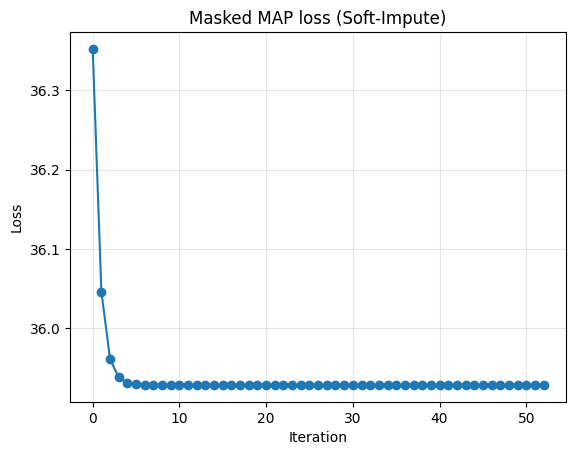

[Part 2] Plotted masked MAP loss.


In [37]:
# --- Cell 5: (Optional) Plot masked loss monotone decrease ---

if res_si["loss_hist"]:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(res_si["loss_hist"], marker='o')
    plt.title("Masked MAP loss (Soft-Impute)")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.show()
    print("[Part 2] Plotted masked MAP loss.")
else:
    print("[Part 2] No loss history was recorded (track_loss=False).")


In [38]:
# --- Cell 6: Stationarity / restart test (crucial) ---

print("[Part 2] Restart test: soft-impute from the converged (U~, V~).")
res_restart = soft_impute(
    Y=Y, R=R, M=M,
    lam=lam if lam_defined else None,
    Lambda=Lambda if Lambda_defined else None,
    init="given", U0=U_tilde, V0=V_tilde,
    maxit=3, tol=1e-12, seed=seed,
    track_loss=False, verbose=True
)

U_restart, V_restart = res_restart["U"], res_restart["V"]
Y_imp_restart = res_restart["Y_imp"]

delta_U = npl.norm(U_restart - U_tilde, 'fro')
delta_V = npl.norm(V_restart - V_tilde, 'fro')
delta_Yimp = npl.norm(Y_imp_restart - Y_imp_final, 'fro')

print(f"[Part 2] Restart deltas (should be ~0): ||ΔU||_F={delta_U:.3e}, ||ΔV||_F={delta_V:.3e}, ||ΔY_imp||_F={delta_Yimp:.3e}")


[Part 2] Restart test: soft-impute from the converged (U~, V~).
[Soft-Impute] n=10, p=8, R=3, missing pi=0.19, tol=1e-12, maxit=3
[Soft-Impute] Using isotropic lam: 2
[Soft-Impute] init mode: given
[Soft-Impute] init from given U0, V0.
[Soft-Impute] Done.
[Soft-Impute] final scales a = [2.7346445  2.24691007 1.2343751 ]
[Part 2] Restart deltas (should be ~0): ||ΔU||_F=1.288e-09, ||ΔV||_F=1.059e-09, ||ΔY_imp||_F=1.378e-09


In [39]:
# --- Cell 7: (Optional) Alternative initialization from a non-top subspace ---

# If in Part 1 you formed (U_star_alt, V_star_alt) by soft-thresholding an alternative set of singular vectors,
# you can test sensitivity by starting from that pair:

try:
    U_target_alt, V_target_alt  # check if they exist
    print("[Part 2] Found alternative soft-thresholded start (U_target_alt, V_target_alt). Running soft-impute...")
    res_si_alt = soft_impute(
        Y=Y, R=R, M=M,
        lam=lam if lam_defined else None,
        Lambda=Lambda if Lambda_defined else None,
        init="given", U0=U_target_alt, V0=V_target_alt,
        maxit=200, tol=1e-10, seed=seed,
        track_loss=True, verbose=True
    )

    def subspace_distance(A, B):
        QA, _ = npl.qr(A); QB, _ = npl.qr(B)
        svals = np.clip(npl.svd(QA.T @ QB, compute_uv=False), 0.0, 1.0)
        return np.sin(np.arccos(svals).max()) if len(svals) else 0.0

    dist_alt_vs_main = subspace_distance(res_si_alt["U"], U_tilde)
    print(f"[Part 2] Subspace distance (alt-run U vs main-run U~): {dist_alt_vs_main:.3e}")

except NameError:
    print("[Part 2] No (U_star_alt, V_star_alt) defined in Part 1; skipping alternative init test.")


[Part 2] Found alternative soft-thresholded start (U_target_alt, V_target_alt). Running soft-impute...
[Soft-Impute] n=10, p=8, R=3, missing pi=0.19, tol=1e-10, maxit=200
[Soft-Impute] Using isotropic lam: 2
[Soft-Impute] init mode: given
[Soft-Impute] init from given U0, V0.
[Soft-Impute] iter   0 | masked MAP loss = 3.676340e+01
[Soft-Impute] iter  10 | rel change (imputed) = 9.592e-04
[Soft-Impute] iter  10 | masked MAP loss = 3.592871e+01
[Soft-Impute] iter  20 | rel change (imputed) = 2.835e-05
[Soft-Impute] iter  20 | masked MAP loss = 3.592863e+01
[Soft-Impute] iter  30 | rel change (imputed) = 8.840e-07
[Soft-Impute] iter  30 | masked MAP loss = 3.592863e+01
[Soft-Impute] iter  40 | rel change (imputed) = 2.763e-08
[Soft-Impute] iter  40 | masked MAP loss = 3.592863e+01
[Soft-Impute] iter  50 | rel change (imputed) = 8.637e-10
[Soft-Impute] iter  50 | masked MAP loss = 3.592863e+01
[Soft-Impute] Converged at iter 57 with rel change 7.637e-11.
[Soft-Impute] Done.
[Soft-Impute] f